In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [100]:
print("python", sys.version)
print("pandas", pd.__version__)

python 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]
pandas 1.2.3


python 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]
pandas 1.2.3

# 1. Подготовка данных #

In [101]:
df = pd.read_csv('games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Сразу видим, что нужно переименовать столбцы: приведем все названия к нижнему регистру

In [102]:
df.set_axis(axis = 'columns', labels=['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'], inplace=True)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### 1.1 Преобразование типов

Посмотрим на типы данных в столбцах:

In [103]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 5.6 MB


Предположим, что набор значений в столбцах genre, rating сильно ограничен. Посмотрим на данные:

In [104]:
df.genre.unique(), df.rating.unique()

(array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
        'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
        'Strategy', nan], dtype=object),
 array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object))

Да, значений в столбцах не очень много, можно заменить их типы на category. 
Проведем следующие преобразования типов столбцов:
- **platform**: оставим как есть
- **year_of_release**: float64 заменим тип на uint16. Для хранения года выпуска игры удобнее будет использовать целочисленный неотрицательный тип uint16 - он может хранить в себе значения в диапазоне от 0 до 65535. Помимо того, что обрабатывать год как целое число несколько удобнее, такой заменой уменьшаем и количество памяти, необходимое для хранения этого столбца - каждое значение типа float64 имеет размер 8 байт, когда как uint16 - 2 байта.
- **genre**: object заменим на category
- **rating**: object заменим на category
- **user_score**: object заменим на float16. Зту замену необходимо произвести, так как в столбце хранится оценка пользователей, которая всегда будет иметь числовое значение.

In [105]:
df['genre'] = df['genre'].astype('category')
df['rating'] = df['rating'].astype('category')

Прежде чем заменить тип столбца **year_of_release**, необходимо обработать пропуски в этом столбце. В выводе функции info() выше видим, что в столбце около 200 пропусков. Убедимся, что пропущенные значения не принадлежат какой-то одной из платформ или значению рейтинга ESRB:

In [106]:
def get_grouped_stats(df, group_column, column, func, first_rows=5, ):
    matched_rows = df[func(df[column])].groupby(group_column)['name'].count()
    matched_rows.name = 'matched_rows_count'    
    rows_count = df.groupby(group_column)['name'].count()
    rows_count.name = 'rows_count'
    result = pd.concat([matched_rows, rows_count], axis=1, join='inner')
    result['rate'] = result.matched_rows_count / result.rows_count
    return result.sort_values(by='rate', ascending=False)[:first_rows]

In [107]:
get_grouped_stats(df, 'platform', 'year_of_release', pd.isnull)

,matched_rows_count,rows_count,rate
platform,,,
2600,17,133,0.127820
Wii,34,1320,0.025758
XB,21,824,0.025485
GC,14,556,0.025180
X360,30,1262,0.023772


In [108]:
get_grouped_stats(df, 'rating', 'year_of_release', pd.isnull)

,matched_rows_count,rows_count,rate
rating,,,
RP,2,3,0.666667
E10+,27,1420,0.019014
T,56,2961,0.018913
E,69,3990,0.017293
M,27,1563,0.017274


Если пропущенные в столбце year_of_release распределены практически равномерно по типам платформ, то в отношении столбца с рейтингом есть интересное замечание. Для 2 из 3 записей с рейтингом RP пропущено значение в столбце year_of_release.
Путем поиска в Яндекс узнаем, что RP значит Rating Pending, т.е. рейтинг ожидается. Посмотрим, что это за игры:

In [109]:
df[df.rating == 'RP']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13672,Clockwork Empires,PC,NaN,Strategy,0.0,0.04,0.0,0.00,58.0,3.8,RP
14270,Supreme Ruler: Cold War,PC,2011.0,Strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP
16180,WRC: FIA World Rally Championship,PC,NaN,Racing,0.0,0.01,0.0,0.00,65.0,NaN,RP


Так как таких строки всего 3, попробуем заполнить данные самостоятельно. Путем поиска на ресурсах [ESRB](https://www.esrb.org/) и [Metacritic](https://www.metacritic.com/) находим следующую информацию:
- **Supreme Ruler: Cold War** [получила](https://www.esrb.org/ratings/31253/Supreme+Ruler+Cold+War/) на ESRB рейтинг E10+
- **WRC: FIA World Rally Championship** [вышла в релиз](https://www.metacritic.com/game/pc/wrc-fia-world-rally-championship) на PC в 2010 году, однако по состоянию на 2021 так и не получила свой уровень рейтинга от ESRB. Можно просто удалить данную запись из таблицы.
- **Clockwork Empires** [вышла в релиз](https://www.metacritic.com/game/pc/clockwork-empires) в 2016 году, но также до сих пор не получила свой рейтинг от ESRB. Также удаляем эту запись, тем самым полностью избавляясь от категории 'RP' в столбце rating

In [110]:
#удаляем ненужные записи
df.drop(df.loc[(df['name']=='WRC: FIA World Rally Championship') & (df['platform']=='PC')].index, inplace=True)
df.drop(df.loc[(df['name']=='Clockwork Empires') & (df['platform']=='PC')].index, inplace=True)

#меняем рейтинг для Supreme Ruler: Cold War
df.loc[df[df.name == 'Supreme Ruler: Cold War'].index, 'rating'] = 'E10+'

#меняем тип столбца rating на category
df.rating.cat.set_categories(df.rating.unique().categories, inplace=True)

In [111]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16711 non-null  object  
 1   platform         16713 non-null  object  
 2   year_of_release  16446 non-null  float64 
 3   genre            16711 non-null  category
 4   na_sales         16713 non-null  float64 
 5   eu_sales         16713 non-null  float64 
 6   jp_sales         16713 non-null  float64 
 7   other_sales      16713 non-null  float64 
 8   critic_score     8135 non-null   float64 
 9   user_score       10013 non-null  object  
 10  rating           9947 non-null   category
dtypes: category(2), float64(6), object(3)
memory usage: 4.4 MB


Видим, что пропуски распределены по разным значениям категориальных переменных. Так как количество пропусков в целом небольшое по сравнению с размером датасета, просто удалим записи с пропущенными значениями в этом столбце. Удалим пропуски и поменяем тип столбца:

In [112]:
#удаляем пропуски в столбце year_of_release
df.dropna(subset=['year_of_release'], inplace=True)
#меняем тип столбца year_of_release на uint16
df['year_of_release'] = df['year_of_release'].astype('uint16')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16446 non-null  object  
 2   year_of_release  16446 non-null  uint16  
 3   genre            16444 non-null  category
 4   na_sales         16446 non-null  float64 
 5   eu_sales         16446 non-null  float64 
 6   jp_sales         16446 non-null  float64 
 7   other_sales      16446 non-null  float64 
 8   critic_score     7983 non-null   float64 
 9   user_score       9839 non-null   object  
 10  rating           9768 non-null   category
dtypes: category(2), float64(5), object(3), uint16(1)
memory usage: 3.8 MB


Помимо большого количества пропусков в столбцах **critic_score**, **user_score**, **rating** остались еще записи с 2 пропусками в столбцах **name** и **genre**. Взглянем на них:

In [113]:
df[df.genre.isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Тоже смело можно удалять:

In [114]:
#удаляем все строки с пропусками в столбцах name и genre
df.dropna(subset=['name', 'genre'], inplace=True)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16444 non-null  object  
 2   year_of_release  16444 non-null  uint16  
 3   genre            16444 non-null  category
 4   na_sales         16444 non-null  float64 
 5   eu_sales         16444 non-null  float64 
 6   jp_sales         16444 non-null  float64 
 7   other_sales      16444 non-null  float64 
 8   critic_score     7983 non-null   float64 
 9   user_score       9839 non-null   object  
 10  rating           9768 non-null   category
dtypes: category(2), float64(5), object(3), uint16(1)
memory usage: 3.8 MB


Дальше необходимо поменять тип в столбце **user_score** на float64, посколько там хранятся оценки пользователей, что явно должно храниться в числовом виде. Однако известно, что в столбце содержатся значения нечислового типа, а именно 'tbd', что означает to be determined, т.е. будет определен в будущем. Посмотрим, сколько таких данных и как они распределены:

In [115]:
df[df['user_score'] == 'tbd'].shape

(2376, 11)

In [116]:
get_grouped_stats(df, 'year_of_release', 'user_score', lambda x: x =='tbd', 10)

,matched_rows_count,rows_count,rate
year_of_release,,,
2009,405,1426,0.284011
2010,331,1255,0.263745
2002,192,829,0.231604
2008,326,1427,0.228451
2011,217,1136,0.191021
2001,82,482,0.170124
2007,192,1197,0.160401
2004,107,762,0.140420
2005,121,939,0.128860


Видно, что таких значений достаточно много. Посмотрим на корреляцию признаков **user_score** и **critic_score**:

In [117]:
df[~df['critic_score'].isnull()]['critic_score'] \
.corr \
(df[(df['user_score'] != 'tbd') & (~df['user_score'].isnull())]['user_score'].astype(float))

0.5796706281932216

Признаки имеют явную корреляцию: чем больше critic_score, тем больше user_score. **Заполним значения 'tbd' в user_score значениями critic_score / 10** и заново посчитаем корреляцию между признаками

In [118]:
df.loc[df[df['user_score'] == 'tbd'].index, 'user_score'] = df[df['user_score'] == 'tbd']['critic_score'] / 10

In [119]:
df[~df['critic_score'].isnull()]['critic_score'] \
.corr \
(df[(df['user_score'] != 'tbd') & (~df['user_score'].isnull())]['user_score'].astype(float))

0.6392295231844175

Корреляция увеличилась не сильно, будем считать такое преобразование user_score приемлимым.
Заменим, наконец, тип столбца user_score на float16:

In [120]:
df['user_score'] = df['user_score'].astype('float16')
df['critic_score'] = df['critic_score'].astype('float16')
df['other_sales'] = df['other_sales'].astype('float16')
df['jp_sales'] = df['jp_sales'].astype('float16')
df['eu_sales'] = df['eu_sales'].astype('float16')
df['na_sales'] = df['na_sales'].astype('float16')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16444 non-null  object  
 2   year_of_release  16444 non-null  uint16  
 3   genre            16444 non-null  category
 4   na_sales         16444 non-null  float16 
 5   eu_sales         16444 non-null  float16 
 6   jp_sales         16444 non-null  float16 
 7   other_sales      16444 non-null  float16 
 8   critic_score     7983 non-null   float16 
 9   user_score       8519 non-null   float16 
 10  rating           9768 non-null   category
dtypes: category(2), float16(6), object(2), uint16(1)
memory usage: 1.1+ MB


### 1.2 Обработка пропусков

Посмотрим теперь на пропуски в столбцах user_score и critic_score. Найдем количество строк, в которых пропущены значения в обоих столбцах:

In [121]:
df[(df.user_score.isnull()) & (df.critic_score.isnull())].shape

(7892, 11)

Таких строк очень много! Можно было бы попробовать восстановить их, например, линейной регрессией, но про машинное обучение мы еще не слышали ;(, да и качество таких данных было бы очень сомнительным (заполнять оценки пользователей или критиков, неблагодарное занятие, на мой взгляд). Поэтому просто удалим безнадежные строки, благо достаточно данных для анализа у нас еще останется

In [122]:
df.drop(df.loc[(df.user_score.isnull()) & (df.critic_score.isnull())].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8552 entries, 0 to 16705
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             8552 non-null   object  
 1   platform         8552 non-null   object  
 2   year_of_release  8552 non-null   uint16  
 3   genre            8552 non-null   category
 4   na_sales         8552 non-null   float16 
 5   eu_sales         8552 non-null   float16 
 6   jp_sales         8552 non-null   float16 
 7   other_sales      8552 non-null   float16 
 8   critic_score     7983 non-null   float16 
 9   user_score       8519 non-null   float16 
 10  rating           8456 non-null   category
dtypes: category(2), float16(6), object(2), uint16(1)
memory usage: 334.8+ KB


Удалим еще ~70 строк с пустым critic_score

In [123]:
df.drop(df.loc[df.critic_score.isnull()].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7983 entries, 0 to 16705
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             7983 non-null   object  
 1   platform         7983 non-null   object  
 2   year_of_release  7983 non-null   uint16  
 3   genre            7983 non-null   category
 4   na_sales         7983 non-null   float16 
 5   eu_sales         7983 non-null   float16 
 6   jp_sales         7983 non-null   float16 
 7   other_sales      7983 non-null   float16 
 8   critic_score     7983 non-null   float16 
 9   user_score       7950 non-null   float16 
 10  rating           7902 non-null   category
dtypes: category(2), float16(6), object(2), uint16(1)
memory usage: 312.6+ KB


и ~80 строк с пустым rating

In [124]:
df.drop(df.loc[df.rating.isnull()].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7902 entries, 0 to 16702
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             7902 non-null   object  
 1   platform         7902 non-null   object  
 2   year_of_release  7902 non-null   uint16  
 3   genre            7902 non-null   category
 4   na_sales         7902 non-null   float16 
 5   eu_sales         7902 non-null   float16 
 6   jp_sales         7902 non-null   float16 
 7   other_sales      7902 non-null   float16 
 8   critic_score     7902 non-null   float16 
 9   user_score       7878 non-null   float16 
 10  rating           7902 non-null   category
dtypes: category(2), float16(6), object(2), uint16(1)
memory usage: 309.4+ KB


Оставшиеся пропуски в строке user_score заполним путем деления на 10 critic_score в соответствующих строках

In [125]:
df.loc[df[df['user_score'].isnull()].index, 'user_score'] = df[df['user_score'].isnull()]['critic_score'] / 10
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7902 entries, 0 to 16702
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             7902 non-null   object  
 1   platform         7902 non-null   object  
 2   year_of_release  7902 non-null   uint16  
 3   genre            7902 non-null   category
 4   na_sales         7902 non-null   float16 
 5   eu_sales         7902 non-null   float16 
 6   jp_sales         7902 non-null   float16 
 7   other_sales      7902 non-null   float16 
 8   critic_score     7902 non-null   float16 
 9   user_score       7902 non-null   float16 
 10  rating           7902 non-null   category
dtypes: category(2), float16(6), object(2), uint16(1)
memory usage: 1.5 MB


Получен датасет с правильными типами данных и с отсутствующими пропусками. Пришлось потерять много данных. Можно идти дальше

# 2. Исследование данных

Добавим столбец с суммарными продажами по всем регионам

In [126]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.375000,28.953125,3.769531,8.453125,76.0,8.000000,E,82.500000
2,Mario Kart Wii,Wii,2008,Racing,15.679688,12.757812,3.789062,3.289062,82.0,8.296875,E,35.500000
3,Wii Sports Resort,Wii,2009,Sports,15.609375,10.929688,3.279297,2.949219,80.0,8.000000,E,32.750000
6,New Super Mario Bros.,DS,2006,Platform,11.281250,9.140625,6.500000,2.880859,89.0,8.500000,E,29.796875
7,Wii Play,Wii,2006,Misc,13.960938,9.179688,2.929688,2.839844,58.0,6.601562,E,28.906250


### 3.1 Распределение количества выпускаемых игр по годам

array([[<AxesSubplot:title={'center':'year_of_release'}>]], dtype=object)

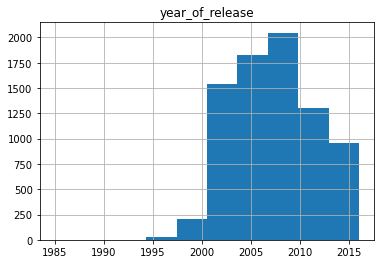

In [127]:
df.hist(column='year_of_release')

Из гистограммы видим, что распределение количества игр имеет левый хвост. Избавимся от хвоста, отсеяв все игры выпущенные до 1998 года

array([[<AxesSubplot:title={'center':'year_of_release'}>]], dtype=object)

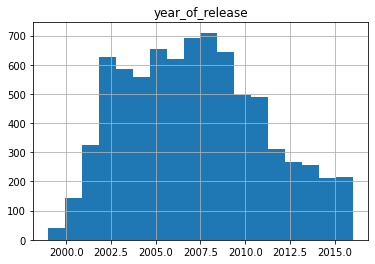

In [128]:
df = df[df['year_of_release'] > 1998]
df.hist(column='year_of_release', bins=df.year_of_release.nunique())

In [129]:
platforms_grouped = df.groupby('platform')['total_sales'].sum()
platforms_grouped.sort_values(ascending=False)

platform
PS2     981.500000
X360    858.500000
PS3     789.000000
Wii     682.000000
DS      434.250000
PS4     243.000000
XB      226.625000
PSP     196.500000
PC      180.000000
GC      169.375000
GBA     166.500000
XOne    129.625000
PS      125.937500
3DS     124.125000
WiiU     66.250000
PSV      30.937500
DC        4.546875
Name: total_sales, dtype: float16

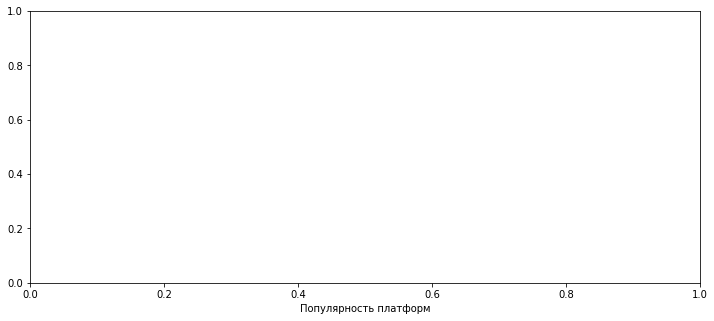

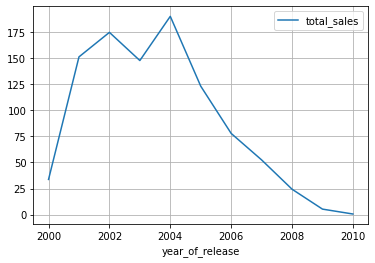

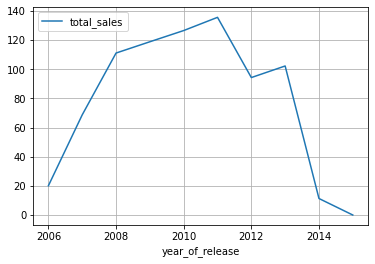

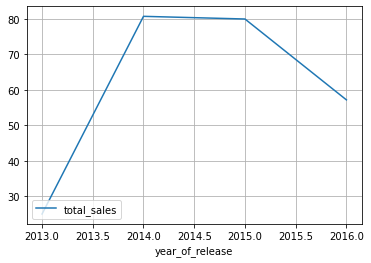

In [146]:
plt.figure(figsize=(12,5))
plt.xlabel('Популярность платформ')

ax1 = df[df.platform == 'PS2'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(grid=True, label='PS2')
ax2 = df[df.platform == 'PS3'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(grid=True, label='PS3')
ax3 = df[df.platform == 'PS4'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(grid=True, label='PS4')

ax1.legend(loc=1)
ax2.legend(loc=2)
ax3.legend(loc=3)

plt.show()

<AxesSubplot:xlabel='year_of_release'>

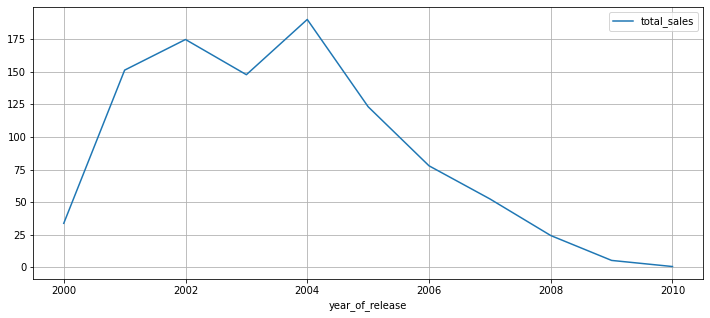

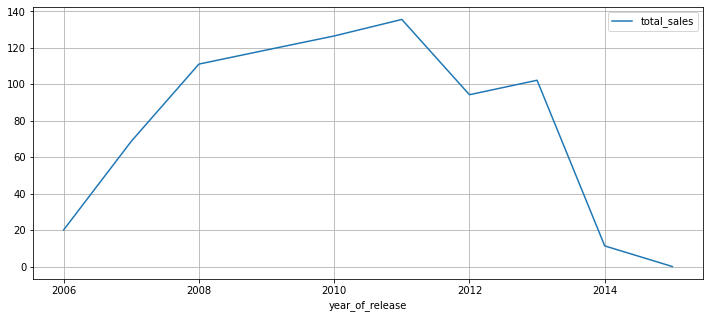

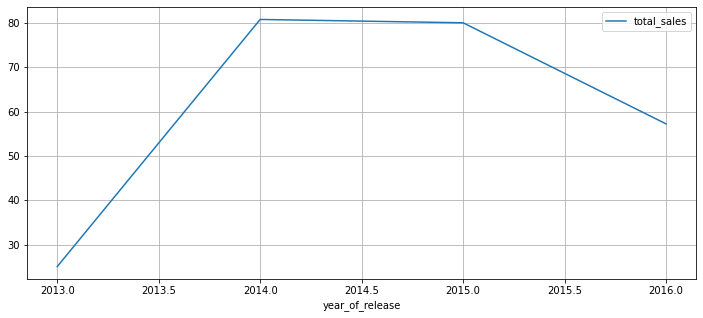

In [145]:
df[df.platform == 'PS2'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(grid=True, figsize=(12, 5))
df[df.platform == 'PS3'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(grid=True, figsize=(12, 5))
df[df.platform == 'PS4'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(grid=True, figsize=(12, 5))

In [ ]:
for

In [137]:
pl2.unstack()

TypeError: No matching signature found

Посмотрим теперь на распределение пропусков в столбцах **critic_score**, **user_score**, **rating** в группировке по столбцам year_of_release и platform:

In [80]:
get_NA_stats(df, 'platform', 'critic_score', 20)

,missing_values_count,rows_count,missing_values_rate
platform,,,
2600,116,116,1.000000
PCFX,1,1,1.000000
WS,6,6,1.000000
TG16,2,2,1.000000
SNES,239,239,1.000000
GB,97,97,1.000000
SCD,6,6,1.000000
SAT,173,173,1.000000
GEN,27,27,1.000000


In [81]:
get_NA_stats(df, 'year_of_release', 'critic_score', 20)

,missing_values_count,rows_count,missing_values_rate
year_of_release,,,
1980,9,9,1.000000
1987,16,16,1.000000
1995,219,219,1.000000
1993,60,60,1.000000
1991,41,41,1.000000
1990,16,16,1.000000
1981,46,46,1.000000
1989,17,17,1.000000
1986,21,21,1.000000


In [98]:
get_NA_stats(df, 'year_of_release', 'user_score', 20)

,missing_values_count,rows_count,missing_values_rate
year_of_release,,,
1980,9,9,1.000000
1987,16,16,1.000000
1995,219,219,1.000000
1993,60,60,1.000000
1991,41,41,1.000000
1990,16,16,1.000000
1981,46,46,1.000000
1989,17,17,1.000000
1986,21,21,1.000000


In [83]:
get_NA_stats(df, 'platform', 'user_score', 20)

,missing_values_count,rows_count,missing_values_rate
platform,,,
2600,116,116,1.000000
PCFX,1,1,1.000000
WS,6,6,1.000000
TG16,2,2,1.000000
SNES,239,239,1.000000
GB,97,97,1.000000
SCD,6,6,1.000000
SAT,173,173,1.000000
GEN,27,27,1.000000


In [84]:
get_NA_stats(df, 'platform', 'rating', 20)

,missing_values_count,rows_count,missing_values_rate
platform,,,
2600,116,116,1.000000
PCFX,1,1,1.000000
WS,6,6,1.000000
TG16,2,2,1.000000
SNES,239,239,1.000000
GB,97,97,1.000000
SCD,6,6,1.000000
SAT,173,173,1.000000
GEN,27,27,1.000000


In [85]:
get_NA_stats(df, 'year_of_release', 'rating', 20)

,missing_values_count,rows_count,missing_values_rate
year_of_release,,,
1980,9,9,1.000000
1987,16,16,1.000000
1995,219,219,1.000000
1993,60,60,1.000000
1991,41,41,1.000000
1990,16,16,1.000000
1981,46,46,1.000000
1989,17,17,1.000000
1986,21,21,1.000000


**После изучения полученной из таблиц информации делаем выводы:**
- для платформ 2600, PCFX, WS, TG16, SNES, GB, SCD, SAT, GEN, GG, N64, NES, NG, 3DO полностью пропущены значения в столбцах rating, user_score, critic_score. Это может быть связано с возрастом этих платформ - все они достаточно старые, в открытом доступе может попросту не быть доступной информации по играм на таких платформах. Игр на этих платформах в датасете не так уж и много, поэтому смело удалим такие строки
- для всех игр начиная с 1980 по 1995 годы полностью пропущены значения в столбцах rating, user_score, critic_score. Скорее всего, платформы, указанные выше, были актуальны как раз с 1980 по 1995 годы. Проверим этот факт:

Построим гистограмму для всех платформ, кроме тех, по которым у нас нет информации в столбцах rating, user_score, critic_score:

<AxesSubplot:>

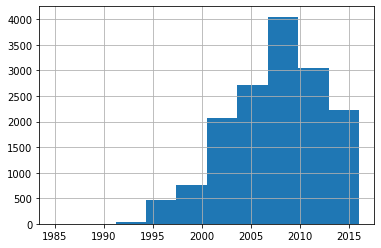

In [93]:
df[~df['platform'].isin(['2600', 'PCFX', 'WS', 'TG16', 'SNES', 'GB', 'SCD', 'SAT', 'GEN', 'GG', 'N64', 'NES', 'NG', '3DO'])]['year_of_release'].hist()

Действительно, получается все указанные платформы с полностью пропущенными оценками пользователей и рейтингами были актуальны с 1985 по 1995 год. Можно смело удалять такие данные:

In [62]:
df = df[~df['platform'].isin(['2600', 'PCFX', 'WS', 'TG16', 'SNES', 'GB', 'SCD', 'SAT', 'GEN', 'GG', 'N64', 'NES', 'NG', '3DO'])]
df = df[df['year_of_release'] > 1995]
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15215 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             15215 non-null  object  
 1   platform         15215 non-null  category
 2   year_of_release  15215 non-null  uint16  
 3   genre            15215 non-null  category
 4   na_sales         15215 non-null  float64 
 5   eu_sales         15215 non-null  float64 
 6   jp_sales         15215 non-null  float64 
 7   other_sales      15215 non-null  float64 
 8   critic_score     7979 non-null   float64 
 9   user_score       9835 non-null   object  
 10  rating           9763 non-null   category
dtypes: category(3), float64(5), object(2), uint16(1)
memory usage: 2.7 MB


In [64]:
df.year_of_release.unique()

array([2006, 2008, 2009, 2005, 2007, 2010, 2013, 2004, 2002, 2001, 2011,
       2015, 2012, 2014, 1997, 1999, 2016, 2003, 1998, 1996, 2000],
      dtype=uint16)

In [29]:
df[df.user_score == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [30]:
df[df.user_score == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [31]:
#создает датафрейм со столбцом NA_rate, в котором для сгруппированного по group_column столбцу датафрейса указано отношение количества строк с пропусками к общему числу строк для столбца с именем column. Результирующий датафрайм сортируется по убыванию NA_rate
def get_tbd_stats(df, group_column, column, first_rows=5):
    with_NA = df[df[column] == 'tbd'].groupby(group_column)['name'].count()
    with_NA.name = 'missing_values_count'    
    rows_count = df.groupby(group_column)['name'].count()
    rows_count.name = 'rows_count'
    result = pd.concat([with_NA, rows_count], axis=1, join='inner')
    result['missing_values_rate'] = result.missing_values_count / result.rows_count
    return result.sort_values(by='missing_values_rate', ascending=False)[:first_rows]

In [32]:
get_tbd_stats(df, 'year_of_release', 'user_score')

,missing_values_count,rows_count,missing_values_rate
year_of_release,,,
2009,405,1426,0.284011
2010,331,1255,0.263745
2002,192,829,0.231604
2008,326,1427,0.228451
2011,217,1136,0.191021
